# Хлорирование вольфрама в присутствии кислорода

Рассматриваемая реакция (фаза WOCl₄ зависит от T):

2 W(s) + 4 Cl₂(g) + O₂(g) → 2 WOCl₄(phase)

Для WOCl₄ используем фазу по температуре: Tm = 204°C (плавление), Tb = 224°C (кипение):
- T < 204°C → WOCl₄(s)
- 204–224°C → WOCl₄(l)
- T ≥ 224°C → WOCl₄(g)

Цели:
- Посчитать тепловой эффект реакции ΔH(T) и изменение энергии Гиббса ΔG(T) при T = 600°C (873.15 K).
- Оценить динамику ΔH(T) и ΔG(T) при изменении температуры.

Источники термоданных: файл `HSC.xlsx` из репозитория (коэф. Cp, H298, S298, Tmin/Tmax). Формулы расчёта берутся из используемой в проекте модели (см. `main.ipynb`). Если нужные вещества не найдутся в `HSC.xlsx`, предусмотрен запасной поиск в `terra.xlsx`.

Допущения:
- Используем стандартные состояния: W — твёрдая фаза (s), Cl₂ — газ (g), O₂ — газ (g), WOCl₄ — фаза по правилу выше.
- H298 — стандартная энтальпия образования (кДж/моль), S298 — стандартная энтропия (Дж/(моль·К)).
- Cp(T) и интегрирование по T — как в `main.ipynb`.

In [2]:
# Импорт и загрузка термоданных
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path(r"c:\IDE\repository\thermo_calculations")

# Пытаемся прочитать главную таблицу HSC.xlsx, при ошибке используем terra.xlsx
sources = [DATA_DIR / 'HSC.xlsx', DATA_DIR / 'terra.xlsx']
for src in sources:
    if src.exists():
        try:
            df = pd.read_excel(src)
            data_source = src.name
            break
        except Exception as e:
            last_err = e
else:
    raise FileNotFoundError("Не найден HSC.xlsx/terra.xlsx или ошибка чтения")

df.head(), data_source

(  Formula Structure FirstName SecondName Phase        CAS  MeltingPoint  \
 0      Ac       NaN  Actinium        NaN     s  7440-34-8       1324.15   
 1      Ac       NaN  Actinium        NaN     l  7440-34-8       1324.15   
 2   Ac(g)       NaN  Actinium        NaN     g  7440-34-8       1324.15   
 3   Ac(g)       NaN  Actinium        NaN     g  7440-34-8       1324.15   
 4   Ac(g)       NaN  Actinium        NaN     g  7440-34-8       1324.15   
 
    BoilingPoint  Density  Solubility  ...     Tmin    Tmax         f1  \
 0       3471.15    10.07         0.0  ...   298.15  1323.0  23.799431   
 1       3471.15     0.00         0.0  ...  1323.00  5000.0  42.000002   
 2       3471.15     0.00         0.0  ...   298.15  1200.0  -3.419130   
 3       3471.15     0.00         0.0  ...  1200.00  2300.0  59.806450   
 4       3471.15     0.00         0.0  ...  2300.00  6000.0  -0.296920   
 
          f2          f3         f4   f5   f6  ReliabilityClass  \
 0  10.73233    0.000560   0.

In [3]:
# Функции терморасчёта на основе формул из main.ipynb
T_REF = 298.15

# Имена коэффициентов в таблице (как в main.ipynb)
CP_COEFFS = ['f1','f2','f3','f4','f5','f6']


def cp_function_from_row(row):
    f1 = row.get('f1', 0) or 0
    f2 = row.get('f2', 0) or 0
    f3 = row.get('f3', 0) or 0
    f4 = row.get('f4', 0) or 0
    f5 = row.get('f5', 0) or 0
    f6 = row.get('f6', 0) or 0

    def cp(T):
        T = float(T)
        return (
            f1
            + f2*T/1000
            + f3*T**(-2) * 100_000
            + f4*T**2 / 1_000_000
            + f5*T**(-3) * 1_000
            + f6*T**3 * 1e-9
        )
    return cp


def H_S_G_from_row(row, T):
    T = float(T)
    H298 = (row.get('H298', 0) or 0) * 1000  # кДж/моль -> Дж/моль
    S298 = row.get('S298', 0) or 0           # Дж/(моль·К)

    cp = cp_function_from_row(row)

    if abs(T - T_REF) < 1e-9:
        H = H298
        S = S298
        G = H - T*S
        return H, S, G

    # Интегрирование по T (трапецией)
    num = 400
    Ts = np.linspace(T_REF, T, num)
    cps = np.array([cp(t) for t in Ts])
    dH = np.trapezoid(cps, Ts)
    dS = np.trapezoid(cps / Ts, Ts)

    H = H298 + dH
    S = S298 + dS
    G = H - T*S
    return H, S, G

In [4]:
# Фиксированные (проверенные) строки термоданных по индексам df.iloc
# Эти строки будут использоваться во всех расчётах
Cl2_g_298_1500   = df.iloc[269282]
W_s_450_2500     = df.iloc[112313]
WOCl4_g_298_600  = df.iloc[56393]
WOCl4_g_600_1700 = df.iloc[56394]
O2_g_298_700     = df.iloc[106174]
O2_g_700_1200    = df.iloc[106175]
WCl6_g_298_1000  = df.iloc[112406]

# Селекторы по температуре для диапазонных веществ (без поиска)

def pick_O2_row(T: float):
    return O2_g_298_700 if float(T) <= 700.0 else O2_g_700_1200


def pick_WOCl4_g_row(T: float):
    return WOCl4_g_298_600 if float(T) <= 600.0 else WOCl4_g_600_1700

In [5]:
# Выбор строк веществ (только фиксированные индексы, без поиска)

# Температура расчёта задаётся ниже; создадим функцию, возвращающую набор species по T

def get_species_rows(T):
    row_W_T = W_s_450_2500
    row_Cl2_T = Cl2_g_298_1500
    row_O2_T = pick_O2_row(T)
    row_WOCl4_T = pick_WOCl4_g_row(T)

    rows = {
        'W(s)': row_W_T,
        'Cl2(g)': row_Cl2_T,
        'O2(g)': row_O2_T,
        'WOCl4(g)': row_WOCl4_T,
    }
    return rows

# Инфо и проверка температурных диапазонов для примера 600°C
T_c_example = 600.0
T_k_example = T_c_example + 273.15
rows = get_species_rows(T_k_example)
info = {}
for k, r in rows.items():
    Tmin = r.get('Tmin', np.nan)
    Tmax = r.get('Tmax', np.nan)
    info[k] = (Tmin, Tmax)
info

{'W(s)': (np.float64(450.0), np.float64(2500.0)),
 'Cl2(g)': (np.float64(298.15), np.float64(1500.0)),
 'O2(g)': (np.float64(700.0), np.float64(1200.0)),
 'WOCl4(g)': (np.float64(600.0), np.float64(1700.0))}

In [6]:
# Стехиометрия реакции: 2 W + 4 Cl2 + O2 -> 2 WOCl4(g)

species_rows = rows

# Продукт фиксирован: газообразный WOCl4
product_key = 'WOCl4(g)'

nu = {
    'W(s)':  -2,
    'Cl2(g)': -4,
    'O2(g)':  -1,
    product_key: +2,
}


def reaction_H_S_G(T):
    dH = 0.0
    dS = 0.0
    dG = 0.0
    for name, coeff in nu.items():
        H, S, G = H_S_G_from_row(species_rows[name], T)
        dH += coeff * H
        dS += coeff * S
        dG += coeff * G
    return dH, dS, dG


# Расчёт при 600°C
T_c = 600.0
T_k = T_c + 273.15

DH_600, DS_600, DG_600 = reaction_H_S_G(T_k)
# Нормировка на моль продукта (число молей продукта в уравнении реакции)
product_moles = abs(nu[product_key])
print(f"Источник данных: {data_source}")
print(f"Фаза продукта: {product_key}")
print(f"T = {T_c:.1f} °C ({T_k:.2f} K)")
# Приводим к кДж/моль продукта и Дж/(К·моль) для ΔS
print(f"ΔH = {DH_600/1000/product_moles:.2f} кДж/моль")
print(f"ΔS = {DS_600/product_moles:.2f} Дж/(К·моль)")
print(f"ΔG = {DG_600/1000/product_moles:.2f} кДж/моль")

Источник данных: HSC.xlsx
Фаза продукта: WOCl4(g)
T = 600.0 °C (873.15 K)
ΔH = 3.63 кДж/моль
ΔS = 5.51 Дж/(К·моль)
ΔG = -1.17 кДж/моль


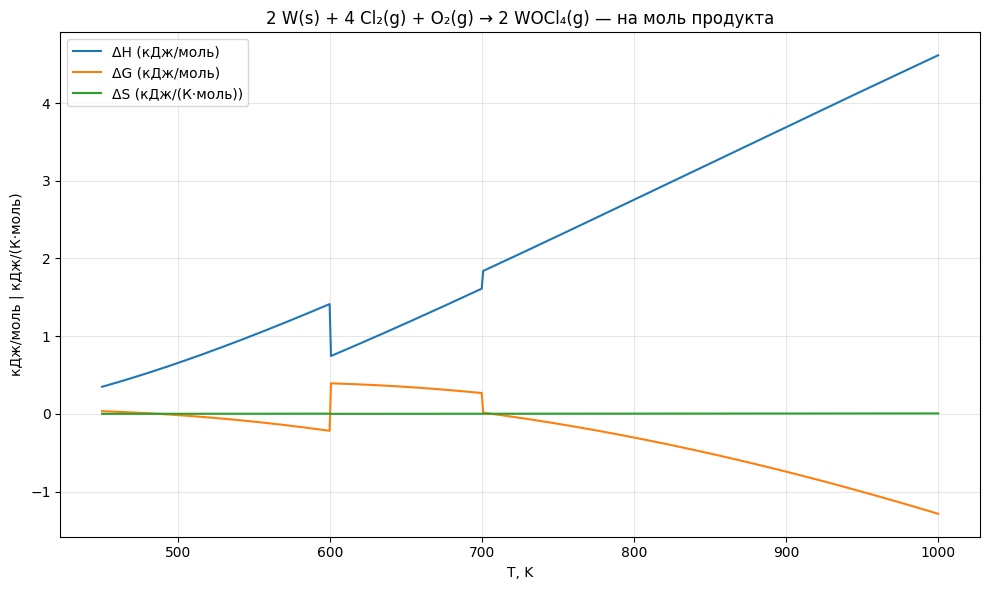

In [7]:
# Графики ΔH(T), ΔG(T), ΔS(T) для газообразного WOCl4: используем проверенные строки
import numpy as np
import matplotlib.pyplot as plt


def cumtrapz_np(y, x):
    # Векторная кумулятивная трапеция (без SciPy)
    dy = (y[..., 1:] + y[..., :-1]) * (x[1:] - x[:-1]) * 0.5
    return np.concatenate([np.zeros(y.shape[:-1] + (1,)), np.cumsum(dy, axis=-1)], axis=-1)


def H_S_G_arrays(row, Ts):
    # Векторный расчёт H(T), S(T), G(T) по формуле из H_S_G_from_row
    H298 = (row.get('H298', 0) or 0) * 1000.0
    S298 = row.get('S298', 0) or 0.0
    # Объединяем T_REF и Ts для единой сетки интегрирования
    Ts_sorted = np.sort(np.unique(np.concatenate([[T_REF], Ts])))
    # Cp на сетке (векторная формула)
    f1 = row.get('f1', 0) or 0.0
    f2 = row.get('f2', 0) or 0.0
    f3 = row.get('f3', 0) or 0.0
    f4 = row.get('f4', 0) or 0.0
    f5 = row.get('f5', 0) or 0.0
    f6 = row.get('f6', 0) or 0.0
    T = Ts_sorted
    Cp_grid = (
        f1
        + f2*T/1000.0
        + f3*T**(-2) * 100_000.0
        + f4*T**2 / 1_000_000.0
        + f5*T**(-3) * 1_000.0
        + f6*T**3 * 1e-9
    )
    dH_grid = cumtrapz_np(Cp_grid, T)  # от T_REF до каждого узла
    dS_grid = cumtrapz_np(Cp_grid / T, T)
    # Индексы Ts в объединённой сетке
    idx = np.searchsorted(Ts_sorted, Ts)
    dH = dH_grid[idx]
    dS = dS_grid[idx]
    H = H298 + dH
    S = S298 + dS
    G = H - Ts * S
    return H, S, G


def validity_mask(row, Ts):
    tmin = float(row.get('Tmin', -np.inf))
    tmax = float(row.get('Tmax', np.inf))
    return (tmin <= Ts) & (Ts <= tmax)


# Диапазон построения берём по пересечению доступных Tmin/Tmax
Tmin_plot = max(float(W_s_450_2500.Tmin), float(Cl2_g_298_1500.Tmin), float(O2_g_298_700.Tmin), float(WOCl4_g_298_600.Tmin))
Tmax_plot = min(float(W_s_450_2500.Tmax), float(Cl2_g_298_1500.Tmax), float(O2_g_700_1200.Tmax), float(WOCl4_g_600_1700.Tmax))
# Сдвигаем в разумные границы
Tmin_plot = max(Tmin_plot, 450.0)
Tmax_plot = min(Tmax_plot, 1000.0)
N = 600
Ts = np.linspace(Tmin_plot, Tmax_plot, N)

# Выбор строк по Ts: O2 и WOCl4 имеют два диапазона — делаем покоординатный выбор
row_W   = W_s_450_2500
row_Cl2 = Cl2_g_298_1500
# Маски по порогам
mask_O2_first   = Ts <= 700.0
mask_WO_first   = Ts <= 600.0

# Векторные H,S,G для всех компонентов
HW, SW, GW = H_S_G_arrays(row_W, Ts)
HCl2, SCl2, GCl2 = H_S_G_arrays(row_Cl2, Ts)
# O2
HO2_1, SO2_1, GO2_1 = H_S_G_arrays(O2_g_298_700, Ts)
HO2_2, SO2_2, GO2_2 = H_S_G_arrays(O2_g_700_1200, Ts)
HO2  = np.where(mask_O2_first, HO2_1, HO2_2)
SO2  = np.where(mask_O2_first, SO2_1, SO2_2)
GO2  = np.where(mask_O2_first, GO2_1, GO2_2)
# WOCl4(g)
HWO_1, SWO_1, GWO_1 = H_S_G_arrays(WOCl4_g_298_600, Ts)
HWO_2, SWO_2, GWO_2 = H_S_G_arrays(WOCl4_g_600_1700, Ts)
HWO = np.where(mask_WO_first, HWO_1, HWO_2)
SWO = np.where(mask_WO_first, SWO_1, SWO_2)
GWO = np.where(mask_WO_first, GWO_1, GWO_2)

# Нормировка на моль продукта (в уравнении 2 моль WOCl4)
product_moles = 2.0

# Реакционные массивы, нормированные на моль продукта
DHs = (-2*HW - 4*HCl2 - 1*HO2 + 2*HWO) / 1000.0 / product_moles           # кДж/моль продукта
DSs_kJ_per_K = (-2*SW - 4*SCl2 - 1*SO2 + 2*SWO) / 1000.0 / product_moles  # кДж/(К·моль продукта)
DGs = (-2*GW - 4*GCl2 - 1*GO2 + 2*GWO) / 1000.0 / product_moles           # кДж/моль продукта

# Валидация диапазонов для каждой точки
valid_W   = validity_mask(row_W, Ts)
valid_Cl2 = validity_mask(row_Cl2, Ts)
valid_O2  = np.where(mask_O2_first, validity_mask(O2_g_298_700, Ts), validity_mask(O2_g_700_1200, Ts))
valid_WO  = np.where(mask_WO_first, validity_mask(WOCl4_g_298_600, Ts), validity_mask(WOCl4_g_600_1700, Ts))
valids = valid_W & valid_Cl2 & valid_O2 & valid_WO

# Единый график
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Валидные участки с подписями
ax.plot(Ts[valids], DHs[valids], color='C0', label='ΔH (кДж/моль)')
ax.plot(Ts[valids], DGs[valids], color='C1', label='ΔG (кДж/моль)')
ax.plot(Ts[valids], DSs_kJ_per_K[valids], color='C2', label='ΔS (кДж/(К·моль))')
# Невалидные участки без подписей, пунктир
if (~valids).any():
    ax.plot(Ts[~valids], DHs[~valids], color='C0', linestyle='--', alpha=0.5)
    ax.plot(Ts[~valids], DGs[~valids], color='C1', linestyle='--', alpha=0.5)
    ax.plot(Ts[~valids], DSs_kJ_per_K[~valids], color='C2', linestyle='--', alpha=0.5)

# Подписи и заголовок с уравнением реакции
ax.set_xlabel('T, K')
ax.set_ylabel('кДж/моль | кДж/(К·моль)')
ax.set_title('2 W(s) + 4 Cl₂(g) + O₂(g) → 2 WOCl₄(g) — на моль продукта')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
# Расчёт реакции W(s) + 3 Cl2(g) → WCl6(g) при 600°C (873.15 K)
# Используем только фиксированные строки

# Температура
T_c_wc = 600.0
T_k_wc = T_c_wc + 273.15

# Фиксированные строки для реагентов и продукта
row_W_wc    = W_s_450_2500
row_Cl2_wc  = Cl2_g_298_1500
row_WCl6_wc = WCl6_g_298_1000

species_rows_wc = {
    'W(s)': row_W_wc,
    'Cl2(g)': row_Cl2_wc,
    'WCl6(g)': row_WCl6_wc,
}

nu_wc = {
    'W(s)': -1,
    'Cl2(g)': -3,
    'WCl6(g)': +1,
}


def reaction_H_S_G_wc(T):
    dH = 0.0
    dS = 0.0
    dG = 0.0
    for name, coeff in nu_wc.items():
        H, S, G = H_S_G_from_row(species_rows_wc[name], T)
        dH += coeff * H
        dS += coeff * S
        dG += coeff * G
    return dH, dS, dG

DH_wc, DS_wc, DG_wc = reaction_H_S_G_wc(T_k_wc)

# Нормировка на моль продукта (1 моль WCl6 по стехиометрии)
product_moles_wc = abs(nu_wc['WCl6(g)'])

print("Источник данных:", data_source)
print("Реакция: W(s) + 3 Cl₂(g) → WCl₆(g)")
print(f"T = {T_c_wc:.1f} °C ({T_k_wc:.2f} K)")
print(f"ΔH = {DH_wc/1000/product_moles_wc:.2f} кДж/моль")
print(f"ΔS = {DS_wc/product_moles_wc:.2f} Дж/(К·моль)")
print(f"ΔG = {DG_wc/1000/product_moles_wc:.2f} кДж/моль")

Источник данных: HSC.xlsx
Реакция: W(s) + 3 Cl₂(g) → WCl₆(g)
T = 600.0 °C (873.15 K)
ΔH = 10.62 кДж/моль
ΔS = 19.89 Дж/(К·моль)
ΔG = -6.75 кДж/моль


In [9]:
# Расчёт при 600°C для 2 W(s) + 4 Cl2(g) + O2(g) → 2 WOCl4(g) — на моль продукта
T_c = 600.0
T_k = T_c + 273.15

species_rows_600 = {
    'W(s)': W_s_450_2500,
    'Cl2(g)': Cl2_g_298_1500,
    'O2(g)': pick_O2_row(T_k),
    'WOCl4(g)': pick_WOCl4_g_row(T_k),
}

nu_600 = {
    'W(s)': -2,
    'Cl2(g)': -4,
    'O2(g)': -1,
    'WOCl4(g)': +2,
}

# Суммарные ΔH, ΔS, ΔG и нормировка на моль продукта
sum_dH = 0.0
sum_dS = 0.0
sum_dG = 0.0
for name, coeff in nu_600.items():
    H, S, G = H_S_G_from_row(species_rows_600[name], T_k)
    sum_dH += coeff * H
    sum_dS += coeff * S
    sum_dG += coeff * G

product_moles = 2.0
print(f"Источник данных: {data_source}")
print("2 W(s) + 4 Cl₂(g) + O₂(g) → 2 WOCl₄(g) — на моль продукта")
print(f"T = {T_c:.1f} °C ({T_k:.2f} K)")
print(f"ΔH = {sum_dH/1000/product_moles:.2f} кДж/моль")
print(f"ΔS = {sum_dS/product_moles:.2f} Дж/(К·моль)")
print(f"ΔG = {sum_dG/1000/product_moles:.2f} кДж/моль")

Источник данных: HSC.xlsx
2 W(s) + 4 Cl₂(g) + O₂(g) → 2 WOCl₄(g) — на моль продукта
T = 600.0 °C (873.15 K)
ΔH = 3.63 кДж/моль
ΔS = 5.51 Дж/(К·моль)
ΔG = -1.17 кДж/моль


In [12]:
def calculate_thermodynamic_properties(row, T):
    T = float(T)  # Ensure T is a float to allow negative powers
    T_ref = 298.15  # Reference temperature in K

    if 'Tmin' in row and 'Tmax' in row:
        if T < row['Tmin'] or T > row['Tmax']:
            print(f"Предупреждение: Температура {T} K выходит за пределы допустимого диапазона {row['Tmin']}-{row['Tmax']} K для вещества {row.get('Formula', '')}")

    # Coefficients for heat capacity calculation
    f1 = row['f1'] if 'f1' in row else 0
    f2 = row['f2'] if 'f2' in row else 0
    f3 = row['f3'] if 'f3' in row else 0
    f4 = row['f4'] if 'f4' in row else 0
    f5 = row['f5'] if 'f5' in row else 0
    f6 = row['f6'] if 'f6' in row else 0
    H298 = row['H298'] if 'H298' in row else 0
    S298 = row['S298'] if 'S298' in row else 0

    # Function to calculate Cp at any temperature
    def cp_function(temp):
        return (f1 + f2*temp/1000 + f3*temp**(-2) * 100_000 + 
                f4*temp**2 / 1_000_000 + f5*temp**(-3) * 1_000 + 
                f6*temp**3 * 10**(-9))

    # Current temperature heat capacity
    cp = cp_function(T)

    # If T equals reference temperature, no need for integration
    if abs(T - T_ref) < 1e-6:
        return cp, H298 * 1000, S298, H298 * 1000 - T*S298

    # Numerical integration for enthalpy change (ΔH)
    # ΔH = ∫(T_ref to T) Cp(T) dT
    num_points = 100  # Number of points for numerical integration
    temp_points = np.linspace(T_ref, T, num_points)
    cp_values = np.array([cp_function(t) for t in temp_points])
    delta_H = np.trapezoid(cp_values, temp_points)

    # Numerical integration for entropy change (ΔS)
    # ΔS = ∫(T_ref to T) Cp(T)/T dT
    cp_over_T = cp_values / temp_points
    delta_S = np.trapezoid(cp_over_T, temp_points)

    # Calculate final enthalpy and entropy
    enthalpy = H298 * 1000 + delta_H  # Convert H298 from kJ to J
    entropy = S298 + delta_S

    # Calculate Gibbs free energy
    gibbs_energy = enthalpy - T * entropy

    return cp, enthalpy, entropy, gibbs_energy


def thermodynamic_table(row):
    Tmin = int(row['Tmin'])
    Tmax = int(row['Tmax'])
    # Round up Tmin to the next multiple of 100
    Tmin_rounded = int(np.ceil(Tmin / 100) * 100)
    # Create temperature values in steps of 100
    T_values = np.arange(Tmin_rounded, Tmax + 1, 100)
    results = []
    for T in T_values:
        cp, enthalpy, entropy, gibbs_energy = calculate_thermodynamic_properties(row, T)
        results.append({
            'TK': float(T),
            'Cp': cp,
            'ΔH': enthalpy,
            'ΔS': entropy,
            'ΔG': gibbs_energy
        })
    df = pd.DataFrame(results, columns=['TK', 'Cp', 'ΔH', 'ΔS', 'ΔG'])
    # Round all numeric columns to 1 decimal place
    df = df.round(1)
    return df

thermodynamic_table(WCl6_g_298_1000)

,TK,Cp,ΔH,ΔS,ΔG
0,300.0,144.1,266.5,0.9,-0.8
1,400.0,149.8,14999.9,43.2,-2295.2
2,500.0,152.6,30131.5,77.0,-8364.3
3,600.0,154.2,45473.5,105.0,-17502.2
4,700.0,155.2,60942.5,128.8,-29220.2
5,800.0,155.8,76494.0,149.6,-43162.0
6,900.0,156.3,92101.0,168.0,-59056.8
7,1000.0,156.6,107745.1,184.4,-76692.0
